## Abstract
stock market simulation grounded in a New Keynesian DSGE framework with heterogeneous agents characterized by varied incomes, investment strategies, and access to financial markets

In [2]:
import math
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
import pandas as pd
from itertools import chain
from math import e, log
from sympy import Symbol, symbols
import seaborn as sns

## Heterogeneous Investors

We define the investors/household income process as:
$$y_{it} = p_{it}z_{t}$$
$y_{it}$ is the labor income of investor i at time t, $p_{it}$ is the individual idiosyncratic component, $z_{t}$ is the aggregate shock, or the overall economic conditions.

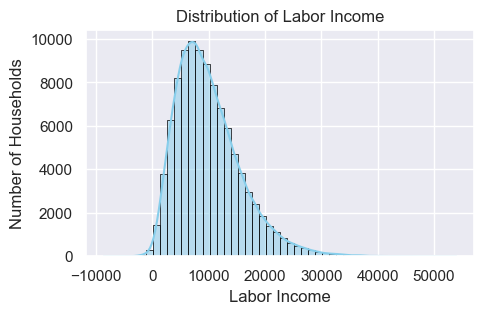

In [300]:
# Setting a random seed for reproducibility
np.random.seed(0)

# Number of investors (here we initialize at 100k)
N = 100000

# The aggregate shock or the overall economic conditions
aggregate_shock = np.random.normal(10000, 3500, N)

# individual idosyncratic shock (endowed individual ability, health, etc.)
# random number between 0 and 1
idiosyncratic_shock = np.random.normal(1, 0.3, N)

# persistence (ability to learn, adapt, etc.)
persistence = np.random.normal(1, 0.3, N)

# The individual idiosyncratic shock process
individual_shock = idiosyncratic_shock * persistence

# The labor income process
labor_income = aggregate_shock * individual_shock

# Use Seaborn's default style for a more aesthetic histogram
sns.set_theme()

# Define the figure with increased size and DPI
fig, ax = plt.subplots(figsize=(5, 3), dpi=100)  # Adjust 'dpi' and 'figsize' as needed

# Plotting the histogram with Seaborn
sns.histplot(labor_income, bins=50, kde=True, ax=ax, color="skyblue", edgecolor="black")

ax.set_title("Distribution of Labor Income", fontsize=12)
ax.set_xlabel("Labor Income", fontsize=12)
ax.set_ylabel("Number of Households", fontsize=12)

plt.show()

### Gini Index
Pre-trading Gini Index

In [303]:
# Gini index for labor income
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

gini_val = gini(labor_income)
print(round(gini_val, 3))

0.314


## Value Investor
The first type of investor is value investor. Their purchase decision is a function of the current interest rate, their subjective valuation of the stock, their savings rate, and their relative risk aversion. 

In [209]:
# Every market participants is randomly divided into 3 groups
# 1. value investors: their prediction of price is based on the fundamental value of the asset
# 2. momentum investors: their prediction of price is based on the past price of the asset
# 3. noise traders: their prediction of price is based on the random noise

interest_rate = 0.05

def value_investors(price, labor_income):
    # subjective evaluation of the fundamental value
    fundamental_value = np.random.normal(100, 5) # assume public inbformation thus valuations are close for all investors 
    # investor also evaluates the risk of the asset
    risk = np.std(price[-100:])
    risk_requirement = np.random.normal(100, 10)
    # if the risk is too high, the investor will not invest
    if risk > risk_requirement:
        return [0, 0, labor_income]
    # savings rate
    savings_rate = np.random.normal(0.2, 0.05)
    # savings
    savings = labor_income * savings_rate
    # average price
    N = random.randint(2, 30)
    ma = np.sum(price[-(N+1): -1])/N
    # prediction over the recovery period
    recovery_rate = np.random.normal(0.1, 0.05)
    # weighting on value vs trend, more on value
    weight = np.random.normal(0.7, 0.1)
    # noise
    noise = np.random.normal(0, 5)
    # prediction
    prediction = price[-1] + weight * recovery_rate * (fundamental_value - price[-1]) + (1 - weight) * recovery_rate * (price[-1] - ma) + noise
    # decision
    if prediction > price[-1] and log(prediction/price[-1]) > interest_rate:
        # buy
        shares_purchased = savings / price[-1]
        # update income
        cash = labor_income - shares_purchased * price[-1]
        return [1, round(shares_purchased), round(cash), round(prediction)]
    # if the prediction is lower than the current price, sell
    elif prediction < price[-1]:
        # sell
        shares_sold = savings / price[-1]
        # update income
        cash = labor_income + shares_sold * price[-1]
        return [-1, round(shares_sold), round(cash), round(prediction)]
    else:
        # hold
        return [0, 0, labor_income, 'none', round(prediction)]
    

price = [100, 90, 90, 82, 71, 110, 113]

pred = value_investors(price, 100000)

print(pred)


[-1, 118, 113323, 111]


## Momentum traders

It's decision to trade is based on the moving average of the previous price with a randomly generated noise

In [236]:
# The second type of investor trades on trend
def momentum_investors(price, labor_income):
    # investor also evaluates the risk of the asset
    risk = np.std(price[-100:])
    risk_requirement = np.random.normal(100, 10)
    # if the risk is too high, the investor will not invest
    if risk > risk_requirement:
        return [0, 0, labor_income]
    # savings rate
    savings_rate = np.random.normal(0.2, 0.05)
    # savings
    savings = labor_income * savings_rate
    # average price
    N = random.randint(2, 30)
    ma = np.sum(price[-(N+1): -1])/N
    # prediction over the recovery period
    recovery_rate = np.random.normal(0.1, 0.05)
    # noise
    noise = np.random.normal(0, 5)
    # prediction
    prediction = price[-1] + recovery_rate * (price[-1] - ma) + noise
    # decision
    if prediction > price[-1] and log(prediction/price[-1]) > interest_rate:
        # buy
        shares_purchased = savings / price[-1]
        # update income
        cash = labor_income - shares_purchased * price[-1]
        return [1, round(shares_purchased), round(cash), round(prediction)]
    # if the prediction is lower than the current price, sell
    elif prediction < price[-1]:
        # sell
        shares_sold = savings / price[-1]
        # update income
        cash = labor_income + shares_sold * price[-1]
        return [-1, round(shares_sold), round(cash), round(prediction)]
    else:
        # hold
        return [0, 0, labor_income, 'none', round(prediction)]
    
pred = momentum_investors(price, 100000)
print(pred)

[1, 172, 80548, 120]


## Noise investors
Those that trade not for profit, but for needs for transaction

In [180]:
# The third type of investor trades on noise
def noise_investors(price, labor_income):
    # investor also evaluates the risk of the asset
    risk = np.std(price[-100:])
    risk_requirement = np.random.normal(100, 10)
    # if the risk is too high, the investor will not invest
    if risk > risk_requirement:
        return [0, 0, labor_income]
    # savings rate
    savings_rate = np.random.normal(0.1, 0.05)
    # savings
    savings = labor_income * savings_rate
    # noise
    noise = np.random.normal(0, 5)
    # prediction
    prediction = price[-1] + noise
    # decision

    if prediction > price[-1]:
        # buy
        shares_purchased = savings / price[-1]
        # update income
        cash = labor_income - shares_purchased * price[-1]
        return [1, round(shares_purchased), round(cash), round(prediction)]
    # if the prediction is lower than the current price, sell
    elif prediction < price[-1]:
        # sell
        shares_sold = savings / price[-1]
        # update income
        cash = labor_income + shares_sold * price[-1]
        return [-1, round(shares_sold), round(cash), round(prediction)]
    else:
        # hold
        return [0, 0, labor_income, 'none', round(prediction)]
    
pred = noise_investors(price, 100000)
print(pred)

[1, 105, 88190, 113]


## Double Auction

In [289]:
# continuous double auction market
# investors submit their orders to the market at random order. Orders are ordered by price and time in 
# the order book. The best bid is marked as optimal_bid (the highest price that investors are willing to pay),
# and the best ask is marked as optimal_ask (the lowest price that investors are willing to sell).
# The market maker will match the best bid and ask, and the price is the average of the two.
# the security price is updated as the average of the best bid and ask (price_mm)


import random

def trading_day(labor_income, price):
    order_book = []
    for i in range(len(labor_income)):
        # investor type
        investor_type = random.randint(1, 4)
        if investor_type == 1:
            pred = value_investors(price, i)
        elif investor_type == 2:
            pred = momentum_investors(price, i)
        else:
            pred = noise_investors(price, i)
            
        if pred[0] == 1:
            # buy
            order_book.append([pred[1], pred[3], 'buy'])
            # update income
            labor_income[i] = pred[2]
        elif pred[0] == -1:
            # sell
            order_book.append([pred[1], pred[3], 'sell'])
            labor_income[i] = pred[2]

    # separate bids and asks
    bids = [order for order in order_book if order[2] == 'buy']
    asks = [order for order in order_book if order[2] == 'sell']

    # sort bids in descending and asks in ascending order by price and then by time
    bids.sort(key=lambda x: (-x[1], x[0]))
    asks.sort(key=lambda x: (x[1], x[0]))

    if bids and asks and bids[0][1] >= asks[0][1]:
        price_mm = (bids[0][1] + asks[0][1]) / 2
        # update the price
        price.append(price_mm)


price = [100, 90, 90, 82, 71, 110, 113]
trading_day(labor_income, price)

print(price)



[100, 90, 90, 82, 71, 110, 113, 119.5]


## Simulation

100k investors trades for 1000 periods:

100%|██████████| 100/100 [06:59<00:00,  4.19s/it]


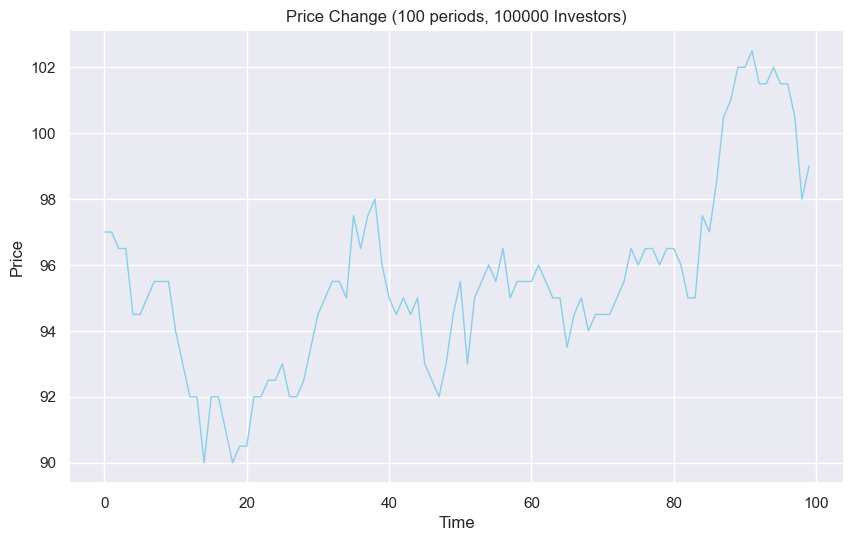

In [311]:
from tqdm import tqdm

# generate a list of prices with 1000 values randomly selected with mean 100 and standard deviation 10
price = [np.random.normal(100, 2) for i in range(100)]

# Gini index for labor income
gini_list = []
# run the trading day for 100 days
for i in tqdm(range(100)):
    trading_day(labor_income, price)
    gini_value = round(gini(labor_income), 3)
    gini_list.append(gini_value)

# only take the last 100 values
price = price[-100:]

# Define the figure with increased size and DPI
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)  # Adjust 'dpi' and 'figsize' as needed

# Plotting the histogram with Seaborn
sns.lineplot(x=range(len(price)), y=price, ax=ax, color="skyblue", linewidth=1)

ax.set_title("Price Change (100 periods, 100000 Investors)", fontsize=12)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Price", fontsize=12)

plt.show()

100%|██████████| 100/100 [06:42<00:00,  4.03s/it]


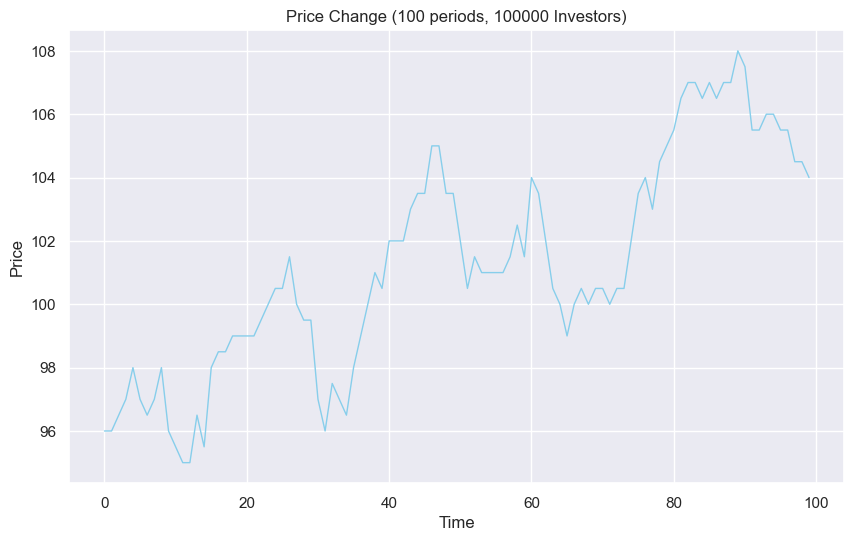

In [314]:
from tqdm import tqdm

# generate a list of prices with 1000 values randomly selected with mean 100 and standard deviation 10
price = [np.random.normal(100, 2) for i in range(100)]

interest_rate = 0.1
# Gini index for labor income
gini_list = []
# run the trading day for 100 days
for i in tqdm(range(100)):
    trading_day(labor_income, price)
    gini_value = round(gini(labor_income), 3)
    gini_list.append(gini_value)

# only take the last 100 values
price = price[-100:]

# Define the figure with increased size and DPI
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)  # Adjust 'dpi' and 'figsize' as needed

# Plotting the histogram with Seaborn
sns.lineplot(x=range(len(price)), y=price, ax=ax, color="skyblue", linewidth=1)

ax.set_title("Price Change (100 periods, 100000 Investors)", fontsize=12)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Price", fontsize=12)

plt.show()